# Analysis of intestine organoid dataset from scEU-seq

Here you will learn how to analyze the intestine organoid dataset from scEU-seq using the using methods in storm that do not rely on steady-state and comparing it to Dynamo method.

In [1]:
import warnings
warnings.filterwarnings('ignore')

import dynamo as dyn
import anndata
import scvelo as scv
import pandas as pd
import numpy as np
import scipy.sparse

from anndata import AnnData
from scipy.sparse import csr_matrix

## Load and preprocess the data

In [2]:
filename = "./data/organoid.h5ad"
organoid = dyn.read(filename)

In [3]:
cell_mapper = {
    '1': 'Enterocytes',
    '2': 'Enterocytes',
    '3': 'Enteroendocrine',
    '4': 'Enteroendocrine progenitor',
    '5': 'Tuft cells',
    '6': 'TA cells',
    '7': 'TA cells',
    '8': 'Stem cells',
    '9': 'Paneth cells',
    '10': 'Goblet cells',
    '11': 'Stem cells',
}

organoid.obs['cell_type'] = organoid.obs.som_cluster_id.map(cell_mapper).astype('str')

In [4]:
adata = organoid.copy()
adata.obs.time = adata.obs.time.astype('str')
adata.obs.loc[adata.obs['time'] == 'dmso', 'time'] = -1
adata.obs['time'] = adata.obs['time'].astype(float)
adata = adata[adata.obs.time != -1, :]
adata = adata[adata.obs.exp_type == 'Pulse', :]

adata.obs.time = adata.obs.time / 60
adata.obs.time = adata.obs.time.astype('float')

adata.obsm['X_umap_ori'] = adata.obs.loc[:, ['rotated_umap1', 'rotated_umap2']].values.astype(float)

adata_dynamo = adata.copy()

In [5]:
# process: storm and celldancer
adata.layers['spliced'] = adata.layers['su'] + adata.layers['sl']
adata.layers['unspliced'] = adata.layers['uu'] + adata.layers['ul']

dyn.pp.recipe_monocle(
    adata,
    n_top_genes=1000,
    total_layers=False,
    # total_layers=True,
    experiment_type='one-shot',
    keep_raw_layers=True,
    keep_filtered_genes=False,
)
dyn.tl.moments(adata)
adata.layers['M_u'] = adata.layers['M_u'].toarray()
adata.layers['M_s'] = adata.layers['M_s'].toarray()

adata_storm = adata.copy()
adata_celldancer = adata.copy()

|-----> recipe_monocle_keep_filtered_cells_key is None. Using default value from DynamoAdataConfig: recipe_monocle_keep_filtered_cells_key=True
|-----> apply Monocole recipe to adata...
|-----> <insert> pp to uns in AnnData Object.
|-----------> <insert> has_splicing to uns['pp'] in AnnData Object.
|-----------> <insert> has_labling to uns['pp'] in AnnData Object.
|-----------> <insert> splicing_labeling to uns['pp'] in AnnData Object.
|-----------> <insert> has_protein to uns['pp'] in AnnData Object.
|-----> ensure all cell and variable names unique.
|-----> ensure all data in different layers in csr sparse matrix format.
|-----> ensure all labeling data properly collapased
|-----? 
When analyzing labeling based scRNA-seq without providing `tkey`, dynamo will try to use 
 `time` as the key for labeling time. Please correct this via supplying the correct `tkey`
if needed.
|-----> detected experiment type: one-shot
|-----------> <insert> tkey to uns['pp'] in AnnData Object.
|-----------

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


|-----> [moments calculation] in progress: 100.0000%
|-----> [moments calculation] finished [8.8263s]


In [6]:
# process: dynamo
adata_dynamo.layers['new'], adata_dynamo.layers['total'] = adata_dynamo.layers['ul'] + adata_dynamo.layers['sl'], adata_dynamo.layers['su'] + adata_dynamo.layers['sl'] + adata_dynamo.layers['uu'] + adata_dynamo.layers['ul']
del adata_dynamo.layers['uu'], adata_dynamo.layers['ul'], adata_dynamo.layers['su'], adata_dynamo.layers['sl']

dyn.pp.recipe_monocle(
    adata_dynamo,
    n_top_genes=1000,
    total_layers=False,
    # total_layers=True,
    experiment_type='one-shot',
    keep_raw_layers=True,
    keep_filtered_genes=False,
)

|-----> recipe_monocle_keep_filtered_cells_key is None. Using default value from DynamoAdataConfig: recipe_monocle_keep_filtered_cells_key=True
|-----> apply Monocole recipe to adata...
|-----> <insert> pp to uns in AnnData Object.
|-----------> <insert> has_splicing to uns['pp'] in AnnData Object.
|-----------> <insert> has_labling to uns['pp'] in AnnData Object.
|-----------> <insert> splicing_labeling to uns['pp'] in AnnData Object.
|-----------> <insert> has_protein to uns['pp'] in AnnData Object.
|-----> ensure all cell and variable names unique.
|-----> ensure all data in different layers in csr sparse matrix format.
|-----> ensure all labeling data properly collapased
|-----? 
When analyzing labeling based scRNA-seq without providing `tkey`, dynamo will try to use 
 `time` as the key for labeling time. Please correct this via supplying the correct `tkey`
if needed.
|-----> detected experiment type: one-shot
|-----------> <insert> tkey to uns['pp'] in AnnData Object.
|-----------

In [7]:
# run scvelo
scv.pp.filter_and_normalize(adata_storm, n_top_genes=adata_storm.n_vars, enforce=True)
scv.pp.moments(adata_storm, n_pcs=30, n_neighbors=30)
# dyn.tl.moments(adata_storm)
# adata_storm.layers['Mu'] = adata_storm.layers['M_u']
# adata_storm.layers['Ms'] = adata_storm.layers['M_s']
scv.tl.recover_dynamics(adata_storm, var_names='all', max_iter=50)

from CSP4ML import select_scv_genes
import numpy as np

# calculate the goodness of fit of the scvelo method and select well-fitting genes
select_scv_genes(adata_storm)
r2_thr = np.quantile(adata_storm.var['no_linear_r2'].values, 0.995)

Normalized count data: X, spliced, unspliced.
Extracted 1000 highly variable genes.
computing neighbors
    finished (0:00:01) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
recovering dynamics (using 1/12 cores)


  0%|          | 0/1000 [00:00<?, ?gene/s]

    finished (0:03:23) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)


select scvelo gene: 1000it [00:00, 3913.25it/s]


## Parameter inference and calculation of RNA velocity

In [8]:
# for methods in storm that do not rely on steady-state

adata_storm.uns["pp"]["experiment_type"] = 'kin'
dyn.tl.dynamics(adata_storm,
                model="deterministic",
                est_method='osnoss',
                tkey='time'
                )
dyn.tl.reduceDimension(adata_storm, reduction_method='umap')
dyn.tl.cell_velocities(adata_storm, enforce=True, vkey='velocity_S', ekey='M_s', basis='umap_ori',
                      transition_genes=list(set(adata_storm.var_names[adata_storm.var['no_linear_r2'] > r2_thr] &
                      set(adata_storm.var_names[adata_storm.var['gamma_r2'] > 0]))))

|-----> dynamics_del_2nd_moments_key is None. Using default value from DynamoAdataConfig: dynamics_del_2nd_moments_key=False
|-----? You used tkey time (or group None), but you have calculated local smoothing (1st moment) for your data before. Please ensure you used the desired tkey or group when the smoothing was performed. Try setting re_smooth = True if not sure.
|-----> experiment type: kin, method: osnoss, model: deterministic


Estimate gamma via linear regression of t vs. -ln(1-K): 1000it [00:00, 1976.72it/s]
Infer parameters via maximum likelihood estimation based on the ICSP model and scVelo: 1000it [00:01, 872.06it/s]


(1000, 1)
|-----> retrive data for non-linear dimension reduction...
|-----> perform umap...
|-----> [dimension_reduction projection] in progress: 100.0000%
|-----> [dimension_reduction projection] finished [8.2309s]
|-----? 
Your data has both labeling / splicing data, please ensuring using the right `basis` ({basis}):
   when using `velocity_S`, please use basis based on X_spliced data;
   when using `velocity_T, please use basis based X_total. 
If not sure the data in adata.X, you may need to set `basis='X_spliced_umap'`(`basis='X_total_umap'`) when using `velocity_S` (`velocity_T`). 
|-----> 0 genes are removed because of nan velocity values.
|-----> [calculating transition matrix via pearson kernel with sqrt transform.] in progress: 100.0000%
|-----> [calculating transition matrix via pearson kernel with sqrt transform.] finished [0.4220s]
|-----> [projecting velocity vector to low dimensional embedding] in progress: 100.0000%
|-----> [projecting velocity vector to low dimensional

AnnData object with n_obs × n_vars = 1373 × 1000
    obs: 'well_id', 'batch_id', 'treatment_id', 'log10_gfp', 'rotated_umap1', 'rotated_umap2', 'som_cluster_id', 'monocle_branch_id', 'monocle_pseudotime', 'exp_type', 'time', 'cell_type', 'nGenes', 'nCounts', 'pMito', 'pass_basic_filter', 'sl_Size_Factor', 'initial_sl_cell_size', 'total_Size_Factor', 'initial_total_cell_size', 'su_Size_Factor', 'initial_su_cell_size', 'unspliced_Size_Factor', 'initial_unspliced_cell_size', 'uu_Size_Factor', 'initial_uu_cell_size', 'spliced_Size_Factor', 'initial_spliced_cell_size', 'new_Size_Factor', 'initial_new_cell_size', 'Size_Factor', 'initial_cell_size', 'ul_Size_Factor', 'initial_ul_cell_size', 'ntr', 'cell_cycle_phase', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_counts'
    var: 'ID', 'NAME', 'nCells', 'nCounts', 'pass_basic_filter', 'log_m', 'score', 'log_cv', 'use_for_pca', 'frac', 'ntr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable', 'fit_alpha', 'fit

In [9]:
# for Dynamo

adata_dynamo.uns["pp"]["experiment_type"] = 'one-shot'
dyn.tl.dynamics(adata_dynamo,
                model="deterministic",
                )
dyn.tl.reduceDimension(adata_dynamo, reduction_method='umap')
dyn.tl.cell_velocities(adata_dynamo, enforce=True, vkey='velocity_T', ekey='M_t', basis='umap_ori')

|-----> dynamics_del_2nd_moments_key is None. Using default value from DynamoAdataConfig: dynamics_del_2nd_moments_key=False
|-----> calculating first/second moments...
|-----> [moments calculation] in progress: 100.0000%
|-----> [moments calculation] finished [3.5911s]
|-----? Your adata only has labeling data, but `NTR_vel` is set to be `False`. Dynamo will reset it to `True` to enable this analysis.


estimating gamma: 100%|█████████████████████| 1000/1000 [00:12<00:00, 81.92it/s]


|-----> retrive data for non-linear dimension reduction...
|-----> perform umap...
|-----> [dimension_reduction projection] in progress: 100.0000%
|-----> [dimension_reduction projection] finished [5.5665s]
|-----> incomplete neighbor graph info detected: connectivities and distances do not exist in adata.obsp, indices not in adata.uns.neighbors.
|-----> Neighbor graph is broken, recomputing....
|-----> Start computing neighbor graph...
|-----------> X_data is None, fetching or recomputing...
|-----> fetching X data from layer:None, basis:pca
|-----> method arg is None, choosing methods automatically...
|-----------> method ball_tree selected
|-----> <insert> connectivities to obsp in AnnData Object.
|-----> <insert> distances to obsp in AnnData Object.
|-----> <insert> neighbors to uns in AnnData Object.
|-----> <insert> neighbors.indices to uns in AnnData Object.
|-----> <insert> neighbors.params to uns in AnnData Object.
|-----> 0 genes are removed because of nan velocity values.
|-

AnnData object with n_obs × n_vars = 1373 × 1000
    obs: 'well_id', 'batch_id', 'treatment_id', 'log10_gfp', 'rotated_umap1', 'rotated_umap2', 'som_cluster_id', 'monocle_branch_id', 'monocle_pseudotime', 'exp_type', 'time', 'cell_type', 'nGenes', 'nCounts', 'pMito', 'pass_basic_filter', 'new_Size_Factor', 'initial_new_cell_size', 'Size_Factor', 'initial_cell_size', 'total_Size_Factor', 'initial_total_cell_size', 'ntr', 'cell_cycle_phase'
    var: 'ID', 'NAME', 'nCells', 'nCounts', 'pass_basic_filter', 'log_m', 'score', 'log_cv', 'use_for_pca', 'frac', 'ntr', 'alpha', 'beta', 'gamma', 'half_life', 'alpha_b', 'alpha_r2', 'gamma_b', 'gamma_r2', 'gamma_logLL', 'delta_b', 'delta_r2', 'bs', 'bf', 'uu0', 'ul0', 'su0', 'sl0', 'U0', 'S0', 'total0', 'beta_k', 'gamma_k', 'use_for_dynamics', 'use_for_transition'
    uns: 'pp', 'velocyto_SVR', 'PCs', 'explained_variance_ratio_', 'pca_mean', 'pca_fit', 'feature_selection', 'cell_phase_genes', 'dynamics', 'neighbors', 'umap_fit', 'grid_velocity_umap

In [10]:
# for celldancer
import celldancer as cd
import celldancer.utilities as cdutil
cell_type_u_s = cdutil.adata_to_df_with_embed(adata_celldancer,
                              us_para=['M_u','M_s'],
                              cell_type_para='cell_type',
                              embed_para='X_umap_ori',
                              # save_path='cell_type_u_s.csv',
                              )
loss_df, cellDancer_df=cd.velocity(cell_type_u_s, 
                                   permutation_ratio=0.25,
                                   max_epoches=200,
                                   gene_list=list(adata_celldancer.var_names[adata_celldancer.var.use_for_pca]), 
                                   n_jobs=4)
cellDancer_df=cd.compute_cell_velocity(cellDancer_df=cellDancer_df)
cd.export_velocity_to_dynamo(cellDancer_df, adata_celldancer)

adata_celldancer_temp = cd.to_dynamo(cellDancer_df)
adata_celldancer.layers['velocity_S'] = pd.DataFrame(adata_celldancer_temp.layers['velocity_S'], 
                                        index=adata_celldancer_temp.obs.index, columns=adata_celldancer_temp.var.index).loc[adata_celldancer.obs.index, adata_celldancer.var.index]
adata_celldancer.layers['alpha'] = pd.DataFrame(adata_celldancer_temp.layers['alpha'], 
                                        index=adata_celldancer_temp.obs.index, columns=adata_celldancer_temp.var.index).loc[adata_celldancer.obs.index, adata_celldancer.var.index]
adata_celldancer.layers['beta'] = pd.DataFrame(adata_celldancer_temp.layers['beta'], 
                                        index=adata_celldancer_temp.obs.index, columns=adata_celldancer_temp.var.index).loc[adata_celldancer.obs.index, adata_celldancer.var.index]
adata_celldancer.layers['gamma'] = pd.DataFrame(adata_celldancer_temp.layers['gamma'], 
                                        index=adata_celldancer_temp.obs.index, columns=adata_celldancer_temp.var.index).loc[adata_celldancer.obs.index, adata_celldancer.var.index]
adata_celldancer.uns["dynamics"] = {}
adata_celldancer.uns["dynamics"]["has_splicing"] = True
adata_celldancer.uns["dynamics"]["has_labeling"] = False
dyn.tl.reduceDimension(adata_celldancer)
dyn.tl.cell_velocities(adata_celldancer, enforce=False, vkey='velocity_S', ekey='M_s', basis='umap_ori')

processing:1/1000
processing:2/1000
processing:3/1000
processing:4/1000
processing:5/1000
processing:6/1000
processing:7/1000
processing:8/1000
processing:9/1000
processing:10/1000
processing:11/1000
processing:12/1000
processing:13/1000
processing:14/1000
processing:15/1000
processing:16/1000
processing:17/1000
processing:18/1000
processing:19/1000
processing:20/1000
processing:21/1000
processing:22/1000
processing:23/1000
processing:24/1000
processing:25/1000
processing:26/1000
processing:27/1000
processing:28/1000
processing:29/1000
processing:30/1000
processing:31/1000
processing:32/1000
processing:33/1000
processing:34/1000
processing:35/1000
processing:36/1000
processing:37/1000
processing:38/1000
processing:39/1000
processing:40/1000
processing:41/1000
processing:42/1000
processing:43/1000
processing:44/1000
processing:45/1000
processing:46/1000
processing:47/1000
processing:48/1000
processing:49/1000
processing:50/1000
processing:51/1000
processing:52/1000
processing:53/1000
pr

processing:421/1000
processing:422/1000
processing:423/1000
processing:424/1000
processing:425/1000
processing:426/1000
processing:427/1000
processing:428/1000
processing:429/1000
processing:430/1000
processing:431/1000
processing:432/1000
processing:433/1000
processing:434/1000
processing:435/1000
processing:436/1000
processing:437/1000
processing:438/1000
processing:439/1000
processing:440/1000
processing:441/1000
processing:442/1000
processing:443/1000
processing:444/1000
processing:445/1000
processing:446/1000
processing:447/1000
processing:448/1000
processing:449/1000
processing:450/1000
processing:451/1000
processing:452/1000
processing:453/1000
processing:454/1000
processing:455/1000
processing:456/1000
processing:457/1000
processing:458/1000
processing:459/1000
processing:460/1000
processing:461/1000
processing:462/1000
processing:463/1000
processing:464/1000
processing:465/1000
processing:466/1000
processing:467/1000
processing:468/1000
processing:469/1000
processing:470/1000


processing:835/1000
processing:836/1000
processing:837/1000
processing:838/1000
processing:839/1000
processing:840/1000
processing:841/1000
processing:842/1000
processing:843/1000
processing:844/1000
processing:845/1000
processing:846/1000
processing:847/1000
processing:848/1000
processing:849/1000
processing:850/1000
processing:851/1000
processing:852/1000
processing:853/1000
processing:854/1000
processing:855/1000
processing:856/1000
processing:857/1000
processing:858/1000
processing:859/1000
processing:860/1000
processing:861/1000
processing:862/1000
processing:863/1000
processing:864/1000
processing:865/1000
processing:866/1000
processing:867/1000
processing:868/1000
processing:869/1000
processing:870/1000
processing:871/1000
processing:872/1000
processing:873/1000
processing:874/1000
processing:875/1000
processing:876/1000
processing:877/1000
processing:878/1000
processing:879/1000
processing:880/1000
processing:881/1000
processing:882/1000
processing:883/1000
processing:884/1000



Velocity Estimation:   1%|          | 2/250 [00:12<22:54,  5.54s/it]            /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/sampling.py:252: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df_downsampled=data_df_downsampled.append(data_df_one_gene_downsampled)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib

/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/sampling.py:252: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df_downsampled=data_df_downsampled.append(data_df_one_gene_downsampled)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: Th


Velocity Estimation:   2%|▏         | 4/250 [00:17<14:32,  3.55s/it]            /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/sampling.py:252: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df_downsampled=data_df_downsampled.append(data_df_one_gene_downsampled)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib


Velocity Estimation:   2%|▏         | 5/250 [00:18<11:48,  2.89s/it]            /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib


Velocity Estimation:   2%|▏         | 6/250 [00:22<12:17,  3.02s/it]            /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib


Velocity Estimation:   3%|▎         | 8/250 [00:26<10:15,  2.54s/it]            /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib


Velocity Estimation:   4%|▎         | 9/250 [00:29<11:04,  2.76s/it]            /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib


Velocity Estimation:   4%|▍         | 10/250 [00:32<11:07,  2.78s/it]           /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib


Velocity Estimation:   5%|▍         | 12/250 [00:36<09:45,  2.46s/it]           /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib


Velocity Estimation:   5%|▌         | 13/250 [00:38<08:54,  2.25s/it]           /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib

Velocity Estimation:   6%|▌         | 14/250 [00:41<09:42,  2.47s/it]           /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/sampling.py:252: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df_downsampled=data_df_downsampled.append(data_df_one_gene_downsampled)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/


Velocity Estimation:   6%|▋         | 16/250 [00:45<08:10,  2.10s/it]           /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/sampling.py:252: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df_downsampled=data_df_downsampled.append(data_df_one_gene_downsampled)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib

/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: Th


Velocity Estimation:   8%|▊         | 20/250 [00:53<07:55,  2.07s/it]           /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib

/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/sampling.py:252: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df_downsampled=data_df_downsampled.append(data_df_one_gene_downsampled)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: Th


Velocity Estimation:   9%|▉         | 23/250 [00:59<07:38,  2.02s/it]           /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/sampling.py:252: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df_downsampled=data_df_downsampled.append(data_df_one_gene_downsampled)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib

Velocity Estimation:  10%|▉         | 24/250 [01:01<07:35,  2.02s/it]           /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/sampling.py:252: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df_downsampled=data_df_downsampled.append(data_df_one_gene_downsampled)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/

/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/sampling.py:252: FutureWarning: The frame.app


Velocity Estimation:  10%|█         | 26/250 [01:06<08:46,  2.35s/it]           /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib


Velocity Estimation:  11%|█         | 27/250 [01:10<09:50,  2.65s/it]           /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib


Velocity Estimation:  11%|█         | 28/250 [01:13<09:55,  2.68s/it]           /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib


Velocity Estimation:  12%|█▏        | 30/250 [01:17<08:37,  2.35s/it]           /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib

/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: Th


Velocity Estimation:  13%|█▎        | 33/250 [01:22<07:02,  1.95s/it]           /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib


Velocity Estimation:  14%|█▎        | 34/250 [01:24<06:55,  1.92s/it]           /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib


Velocity Estimation:  15%|█▍        | 37/250 [01:30<07:12,  2.03s/it]           /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib

/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: Th


Velocity Estimation:  16%|█▋        | 41/250 [01:37<06:11,  1.78s/it]           /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib

Velocity Estimation:  17%|█▋        | 42/250 [01:40<06:54,  1.99s/it]           /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/

/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: Th

Velocity Estimation:  18%|█▊        | 45/250 [01:45<06:44,  1.97s/it]           /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/


Velocity Estimation:  18%|█▊        | 46/250 [01:48<06:58,  2.05s/it]           /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib


Velocity Estimation:  19%|█▉        | 48/250 [01:51<06:01,  1.79s/it]           /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib


Velocity Estimation:  20%|█▉        | 49/250 [01:53<05:59,  1.79s/it]           /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib

/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/sampling.py:252: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df_downsampled=data_df_downsampled.append(data_df_one_gene_downsampled)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: Th

/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: Th

/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/sampling.py:252: FutureWarning: The frame.app


Velocity Estimation:  22%|██▏       | 56/250 [02:09<06:47,  2.10s/it]           /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/sampling.py:252: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df_downsampled=data_df_downsampled.append(data_df_one_gene_downsampled)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib

Velocity Estimation:  23%|██▎       | 58/250 [02:13<06:27,  2.02s/it]           /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/


Velocity Estimation:  24%|██▎       | 59/250 [02:15<06:16,  1.97s/it]           /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/sampling.py:252: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df_downsampled=data_df_downsampled.append(data_df_one_gene_downsampled)
/home/pqw/anaconda3/envs/WD/lib


Velocity Estimation:  24%|██▍       | 61/250 [02:19<06:17,  2.00s/it]           /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib


Velocity Estimation:  25%|██▌       | 63/250 [02:22<05:45,  1.85s/it]           /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib


Velocity Estimation:  26%|██▌       | 64/250 [02:24<06:08,  1.98s/it]           /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib

/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: Th


Velocity Estimation:  26%|██▋       | 66/250 [02:29<06:52,  2.24s/it]           /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib


Velocity Estimation:  27%|██▋       | 68/250 [02:42<13:23,  4.41s/it]           /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib

Velocity Estimation:  28%|██▊       | 69/250 [02:44<10:50,  3.59s/it]           /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/sampling.py:252: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df_downsampled=data_df_downsampled.append(data_df_one_gene_downsampled)
/home/pqw/anaconda3/envs/WD/lib/

/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/sampling.py:252: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df_downsampled=data_df_downsampled.append(data_df_one_gene_downsampled)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: Th


Velocity Estimation:  29%|██▉       | 72/250 [02:50<07:41,  2.59s/it]           /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib

/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/sampling.py:252: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df_downsampled=data_df_downsampled.append(data_df_one_gene_downsampled)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: Th


Velocity Estimation:  30%|███       | 76/250 [02:57<05:45,  1.98s/it]           /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib

Velocity Estimation:  31%|███       | 77/250 [02:59<05:23,  1.87s/it]           /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/sampling.py:252: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df_downsampled=data_df_downsampled.append(data_df_one_gene_downsampled)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/


Velocity Estimation:  32%|███▏      | 80/250 [03:04<05:04,  1.79s/it]           /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib

/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: Th


Velocity Estimation:  33%|███▎      | 82/250 [03:09<05:48,  2.07s/it]           /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib


Velocity Estimation:  34%|███▎      | 84/250 [03:13<05:49,  2.10s/it]           /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib

/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/sampling.py:252: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df_downsampled=data_df_downsampled.append(data_df_one_gene_downsampled)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: Th

/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/sampling.py:252: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df_downsampled=data_df_downsampled.append(data_df_one_gene_downsampled)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: Th

/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: Th

/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/sampling.py:252: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df_downsampled=data_df_downsampled.append(data_df_one_gene_downsampled)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: Th


Velocity Estimation:  36%|███▋      | 91/250 [03:32<07:11,  2.71s/it]           /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib

/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/sampling.py:252: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df_downsampled=data_df_downsampled.append(data_df_one_gene_downsampled)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: Th


Velocity Estimation:  38%|███▊      | 94/250 [03:38<06:01,  2.32s/it]           /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/sampling.py:252: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df_downsampled=data_df_downsampled.append(data_df_one_gene_downsampled)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib

Velocity Estimation:  38%|███▊      | 95/250 [03:39<05:13,  2.02s/it]           /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/


Velocity Estimation:  38%|███▊      | 96/250 [03:41<05:29,  2.14s/it]           /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib


Velocity Estimation:  39%|███▉      | 98/250 [03:50<07:29,  2.96s/it]           /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/sampling.py:252: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df_downsampled=data_df_downsampled.append(data_df_one_gene_downsampled)
/home/pqw/anaconda3/envs/WD/lib


Velocity Estimation:  40%|████      | 100/250 [03:54<06:09,  2.47s/it]          /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib


Velocity Estimation:  41%|████      | 102/250 [03:59<06:18,  2.56s/it]          /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/sampling.py:252: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df_downsampled=data_df_downsampled.append(data_df_one_gene_downsampled)
/home/pqw/anaconda3/envs/WD/lib

/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/sampling.py:252: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df_downsampled=data_df_downsampled.append(data_df_one_gene_downsampled)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: Th


Velocity Estimation:  42%|████▏     | 104/250 [04:04<06:08,  2.53s/it]          /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib

/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: Th


Velocity Estimation:  42%|████▏     | 106/250 [04:13<07:52,  3.28s/it]          /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib

Velocity Estimation:  43%|████▎     | 108/250 [04:16<05:51,  2.48s/it]          /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/sampling.py:252: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df_downsampled=data_df_downsampled.append(data_df_one_gene_downsampled)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/

/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/sampling.py:252: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df_downsampled=data_df_downsampled.append(data_df_one_gene_downsampled)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: Th


Velocity Estimation:  44%|████▍     | 110/250 [04:21<05:36,  2.40s/it]          /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib


Velocity Estimation:  45%|████▍     | 112/250 [04:30<07:33,  3.28s/it]          /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/sampling.py:252: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df_downsampled=data_df_downsampled.append(data_df_one_gene_downsampled)
/home/pqw/anaconda3/envs/WD/lib

/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/sampling.py:252: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df_downsampled=data_df_downsampled.append(data_df_one_gene_downsampled)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: Th


Velocity Estimation:  46%|████▌     | 115/250 [04:36<05:24,  2.40s/it]          /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib


Velocity Estimation:  46%|████▋     | 116/250 [04:37<04:55,  2.21s/it]          /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib

/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/sampling.py:252: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df_downsampled=data_df_downsampled.append(data_df_one_gene_downsampled)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: Th


Velocity Estimation:  48%|████▊     | 119/250 [04:48<06:30,  2.98s/it]          /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/sampling.py:252: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df_downsampled=data_df_downsampled.append(data_df_one_gene_downsampled)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib


Velocity Estimation:  48%|████▊     | 120/250 [04:50<05:52,  2.71s/it]          /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib


Velocity Estimation:  49%|████▉     | 122/250 [04:53<04:41,  2.20s/it]          /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/sampling.py:252: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df_downsampled=data_df_downsampled.append(data_df_one_gene_downsampled)
/home/pqw/anaconda3/envs/WD/lib


Velocity Estimation:  50%|████▉     | 124/250 [04:58<04:36,  2.20s/it]          /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib


Velocity Estimation:  50%|█████     | 125/250 [04:59<04:12,  2.02s/it]          /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/sampling.py:252: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df_downsampled=data_df_downsampled.append(data_df_one_gene_downsampled)
/home/pqw/anaconda3/envs/WD/lib


Velocity Estimation:  51%|█████     | 127/250 [05:03<04:05,  2.00s/it]          /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib

Velocity Estimation:  51%|█████     | 128/250 [05:05<04:01,  1.98s/it]          /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/


Velocity Estimation:  52%|█████▏    | 129/250 [05:08<04:11,  2.08s/it]          /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib


Velocity Estimation:  52%|█████▏    | 131/250 [05:12<04:07,  2.08s/it]          /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib

/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: Th


Velocity Estimation:  53%|█████▎    | 133/250 [05:17<04:13,  2.17s/it]          /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib

Velocity Estimation:  54%|█████▍    | 135/250 [05:21<04:04,  2.13s/it]          /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/

/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: Th


Velocity Estimation:  55%|█████▌    | 138/250 [05:27<03:38,  1.95s/it]          /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/sampling.py:252: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df_downsampled=data_df_downsampled.append(data_df_one_gene_downsampled)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib

Velocity Estimation:  56%|█████▌    | 139/250 [05:28<03:15,  1.76s/it]          /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/sampling.py:252: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df_downsampled=data_df_downsampled.append(data_df_one_gene_downsampled)
/home/pqw/anaconda3/envs/WD/lib/


Velocity Estimation:  56%|█████▌    | 140/250 [05:30<03:14,  1.77s/it]          /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib


Velocity Estimation:  57%|█████▋    | 142/250 [05:33<03:06,  1.73s/it]          /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/sampling.py:252: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df_downsampled=data_df_downsampled.append(data_df_one_gene_downsampled)
/home/pqw/anaconda3/envs/WD/lib


Velocity Estimation:  58%|█████▊    | 144/250 [05:37<03:16,  1.85s/it]          /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib

Velocity Estimation:  58%|█████▊    | 145/250 [05:39<03:08,  1.79s/it]          /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/sampling.py:252: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df_downsampled=data_df_downsampled.append(data_df_one_gene_downsampled)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/

/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: Th


Velocity Estimation:  59%|█████▉    | 148/250 [05:43<02:46,  1.63s/it]          /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib

Velocity Estimation:  60%|██████    | 150/250 [05:47<02:41,  1.62s/it]          /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/sampling.py:252: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df_downsampled=data_df_downsampled.append(data_df_one_gene_downsampled)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/

/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/sampling.py:252: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df_downsampled=data_df_downsampled.append(data_df_one_gene_downsampled)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: Th


Velocity Estimation:  62%|██████▏   | 154/250 [05:59<03:47,  2.37s/it]          /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/sampling.py:252: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df_downsampled=data_df_downsampled.append(data_df_one_gene_downsampled)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib

/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/sampling.py:252: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df_downsampled=data_df_downsampled.append(data_df_one_gene_downsampled)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: Th


Velocity Estimation:  62%|██████▏   | 156/250 [06:02<03:17,  2.10s/it]          /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib

Velocity Estimation:  63%|██████▎   | 157/250 [06:04<03:12,  2.07s/it]          /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/

/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/sampling.py:252: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df_downsampled=data_df_downsampled.append(data_df_one_gene_downsampled)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: Th

/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/sampling.py:252: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df_downsampled=data_df_downsampled.append(data_df_one_gene_downsampled)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: Th


Velocity Estimation:  65%|██████▍   | 162/250 [06:15<03:08,  2.14s/it]          /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib

/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: Th

/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: Th


Velocity Estimation:  67%|██████▋   | 167/250 [06:24<02:30,  1.81s/it]          /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib


Velocity Estimation:  67%|██████▋   | 168/250 [06:28<03:07,  2.29s/it]          /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib


Velocity Estimation:  68%|██████▊   | 170/250 [06:32<02:55,  2.19s/it]          /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/sampling.py:252: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df_downsampled=data_df_downsampled.append(data_df_one_gene_downsampled)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib

Velocity Estimation:  68%|██████▊   | 171/250 [06:34<02:39,  2.01s/it]          /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/

/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: Th

Velocity Estimation:  70%|██████▉   | 174/250 [06:40<02:42,  2.14s/it]          /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/sampling.py:252: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df_downsampled=data_df_downsampled.append(data_df_one_gene_downsampled)
/home/pqw/anaconda3/envs/WD/lib/


Velocity Estimation:  70%|███████   | 175/250 [06:42<02:39,  2.13s/it]          /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib


Velocity Estimation:  71%|███████   | 177/250 [06:46<02:31,  2.08s/it]          /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib


Velocity Estimation:  71%|███████   | 178/250 [06:48<02:25,  2.02s/it]          /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib


Velocity Estimation:  72%|███████▏  | 181/250 [06:53<02:06,  1.83s/it]          /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/sampling.py:252: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df_downsampled=data_df_downsampled.append(data_df_one_gene_downsampled)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib

/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: Th


Velocity Estimation:  73%|███████▎  | 183/250 [06:58<02:17,  2.05s/it]          /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib

/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/sampling.py:252: FutureWarning: The frame.app


Velocity Estimation:  75%|███████▍  | 187/250 [07:05<01:56,  1.84s/it]          /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib


Velocity Estimation:  75%|███████▌  | 188/250 [07:07<01:57,  1.90s/it]          /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/sampling.py:252: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df_downsampled=data_df_downsampled.append(data_df_one_gene_downsampled)
/home/pqw/anaconda3/envs/WD/lib


Velocity Estimation:  76%|███████▌  | 190/250 [07:11<01:47,  1.80s/it]          /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib


Velocity Estimation:  76%|███████▋  | 191/250 [07:13<01:53,  1.93s/it]          /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/sampling.py:252: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df_downsampled=data_df_downsampled.append(data_df_one_gene_downsampled)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib


Velocity Estimation:  77%|███████▋  | 193/250 [07:17<01:51,  1.96s/it]          /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib

/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/sampling.py:252: FutureWarning: The frame.app


Velocity Estimation:  79%|███████▉  | 197/250 [07:24<01:32,  1.74s/it]          /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib


Velocity Estimation:  79%|███████▉  | 198/250 [07:26<01:29,  1.72s/it]          /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib


Velocity Estimation:  80%|████████  | 200/250 [07:30<01:32,  1.85s/it]          /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib

/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/sampling.py:252: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df_downsampled=data_df_downsampled.append(data_df_one_gene_downsampled)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: Th

Velocity Estimation:  81%|████████  | 203/250 [07:36<01:30,  1.92s/it]          /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/

/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: Th


Velocity Estimation:  82%|████████▏ | 205/250 [07:40<01:30,  2.01s/it]          /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib


Velocity Estimation:  83%|████████▎ | 207/250 [07:49<02:10,  3.03s/it]          /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/sampling.py:252: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df_downsampled=data_df_downsampled.append(data_df_one_gene_downsampled)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib


Velocity Estimation:  83%|████████▎ | 208/250 [07:51<01:55,  2.75s/it]          /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/sampling.py:252: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df_downsampled=data_df_downsampled.append(data_df_one_gene_downsampled)
/home/pqw/anaconda3/envs/WD/lib


Velocity Estimation:  84%|████████▍ | 210/250 [07:55<01:37,  2.45s/it]          /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib


Velocity Estimation:  84%|████████▍ | 211/250 [07:57<01:25,  2.19s/it]          /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib


Velocity Estimation:  85%|████████▌ | 213/250 [08:00<01:13,  1.98s/it]          /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib

/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)

Velocity Estimation:  86%|████████▌ | 214/250 [08:03<01:17,  2.15s/it]          /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib


Velocity Estimation:  86%|████████▋ | 216/250 [08:11<01:42,  3.02s/it]          /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/sampling.py:252: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df_downsampled=data_df_downsampled.append(data_df_one_gene_downsampled)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib


Velocity Estimation:  87%|████████▋ | 217/250 [08:14<01:33,  2.84s/it]          /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/sampling.py:252: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df_downsampled=data_df_downsampled.append(data_df_one_gene_downsampled)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib

Velocity Estimation:  88%|████████▊ | 219/250 [08:17<01:05,  2.12s/it]          /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/sampling.py:252: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df_downsampled=data_df_downsampled.append(data_df_one_gene_downsampled)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/

/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: Th


Velocity Estimation:  89%|████████▉ | 222/250 [08:23<00:58,  2.07s/it]          /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/sampling.py:252: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df_downsampled=data_df_downsampled.append(data_df_one_gene_downsampled)
/home/pqw/anaconda3/envs/WD/lib


Velocity Estimation:  89%|████████▉ | 223/250 [08:25<00:56,  2.08s/it]          /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib

/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: Th

/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/sampling.py:252: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df_downsampled=data_df_downsampled.append(data_df_one_gene_downsampled)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: Th


Velocity Estimation:  91%|█████████ | 227/250 [08:39<01:13,  3.20s/it]          /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/sampling.py:252: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df_downsampled=data_df_downsampled.append(data_df_one_gene_downsampled)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib

Velocity Estimation:  92%|█████████▏| 229/250 [08:42<00:49,  2.35s/it]          /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/sampling.py:252: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df_downsampled=data_df_downsampled.append(data_df_one_gene_downsampled)
/home/pqw/anaconda3/envs/WD/lib/


Velocity Estimation:  92%|█████████▏| 230/250 [08:44<00:45,  2.26s/it]          /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib


Velocity Estimation:  93%|█████████▎| 232/250 [08:48<00:37,  2.08s/it]          /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib


Velocity Estimation:  93%|█████████▎| 233/250 [08:51<00:36,  2.17s/it]          /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib


Velocity Estimation:  94%|█████████▎| 234/250 [08:52<00:32,  2.06s/it]          /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib

Velocity Estimation:  94%|█████████▍| 236/250 [08:56<00:27,  1.93s/it]          /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/sampling.py:252: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df_downsampled=data_df_downsampled.append(data_df_one_gene_downsampled)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/


Velocity Estimation:  95%|█████████▍| 237/250 [08:58<00:24,  1.87s/it]          /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib


Velocity Estimation:  96%|█████████▌| 239/250 [09:04<00:26,  2.44s/it]          /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/sampling.py:252: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df_downsampled=data_df_downsampled.append(data_df_one_gene_downsampled)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib


Velocity Estimation:  96%|█████████▌| 240/250 [09:06<00:23,  2.38s/it]          /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/sampling.py:252: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df_downsampled=data_df_downsampled.append(data_df_one_gene_downsampled)
/home/pqw/anaconda3/envs/WD/lib


Velocity Estimation:  96%|█████████▋| 241/250 [09:08<00:20,  2.30s/it]          /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib


Velocity Estimation:  97%|█████████▋| 243/250 [09:13<00:16,  2.39s/it]          /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib

Velocity Estimation:  98%|█████████▊| 244/250 [09:16<00:14,  2.44s/it]          /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/sampling.py:252: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df_downsampled=data_df_downsampled.append(data_df_one_gene_downsampled)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/


Velocity Estimation:  98%|█████████▊| 245/250 [09:18<00:12,  2.46s/it]          /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib

/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/sampling.py:252: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df_downsampled=data_df_downsampled.append(data_df_one_gene_downsampled)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: Th


Velocity Estimation:  99%|█████████▉| 247/250 [09:24<00:07,  2.54s/it]          /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/sampling.py:252: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df_downsampled=data_df_downsampled.append(data_df_one_gene_downsampled)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib

/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: Th


Velocity Estimation: 100%|█████████▉| 249/250 [09:28<00:02,  2.45s/it]          /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib

|-----> retrive data for non-linear dimension reduction...
|-----> perform umap...
|-----> [dimension_reduction projection] in progress: 100.0000%
|-----> [dimension_reduction projection] finished [5.8167s]
|-----> incomplete neighbor graph info detected: connectivities and distances do not exist in adata.obsp, indices not in adata.uns.neighbors.
|-----> Neighbor graph is broken, recomputing....
|-----> Start computing neighbor graph...
|-----------> X_data is None, fetching or recomputing...
|-----> fetching X data from layer:None, basis:pca
|-----> method arg is None, choosing methods automatically...
|-----------> method ball_tree selected
|-----> <insert> connectivities to obsp in AnnData Object.
|-----> <insert> distances to obsp in AnnData Object.
|-----> <insert> neighbors to uns in AnnData Object.
|-----> <insert> neighbors.indices to uns in AnnData Object.
|-----> <insert> neighbors.params to uns in AnnData Object.
|-----> 0 genes are removed because of nan velocity values.
|-

AnnData object with n_obs × n_vars = 1373 × 1000
    obs: 'well_id', 'batch_id', 'treatment_id', 'log10_gfp', 'rotated_umap1', 'rotated_umap2', 'som_cluster_id', 'monocle_branch_id', 'monocle_pseudotime', 'exp_type', 'time', 'cell_type', 'nGenes', 'nCounts', 'pMito', 'pass_basic_filter', 'sl_Size_Factor', 'initial_sl_cell_size', 'total_Size_Factor', 'initial_total_cell_size', 'su_Size_Factor', 'initial_su_cell_size', 'unspliced_Size_Factor', 'initial_unspliced_cell_size', 'uu_Size_Factor', 'initial_uu_cell_size', 'spliced_Size_Factor', 'initial_spliced_cell_size', 'new_Size_Factor', 'initial_new_cell_size', 'Size_Factor', 'initial_cell_size', 'ul_Size_Factor', 'initial_ul_cell_size', 'ntr', 'cell_cycle_phase'
    var: 'ID', 'NAME', 'nCells', 'nCounts', 'pass_basic_filter', 'log_m', 'score', 'log_cv', 'use_for_pca', 'frac', 'ntr', 'use_for_dynamics', 'use_for_transition'
    uns: 'pp', 'velocyto_SVR', 'PCs', 'explained_variance_ratio_', 'pca_mean', 'pca_fit', 'feature_selection', 'cell_

## Visualization

Change the settings for better visualization:

In [15]:
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
sc.set_figure_params(scanpy=True, fontsize=6)
figsize = (6, 4)
dpi = 600
path = './rev_figures/figure3/streamline/'

### Streamline plots in UMAP space

<Figure size 600x400 with 0 Axes>

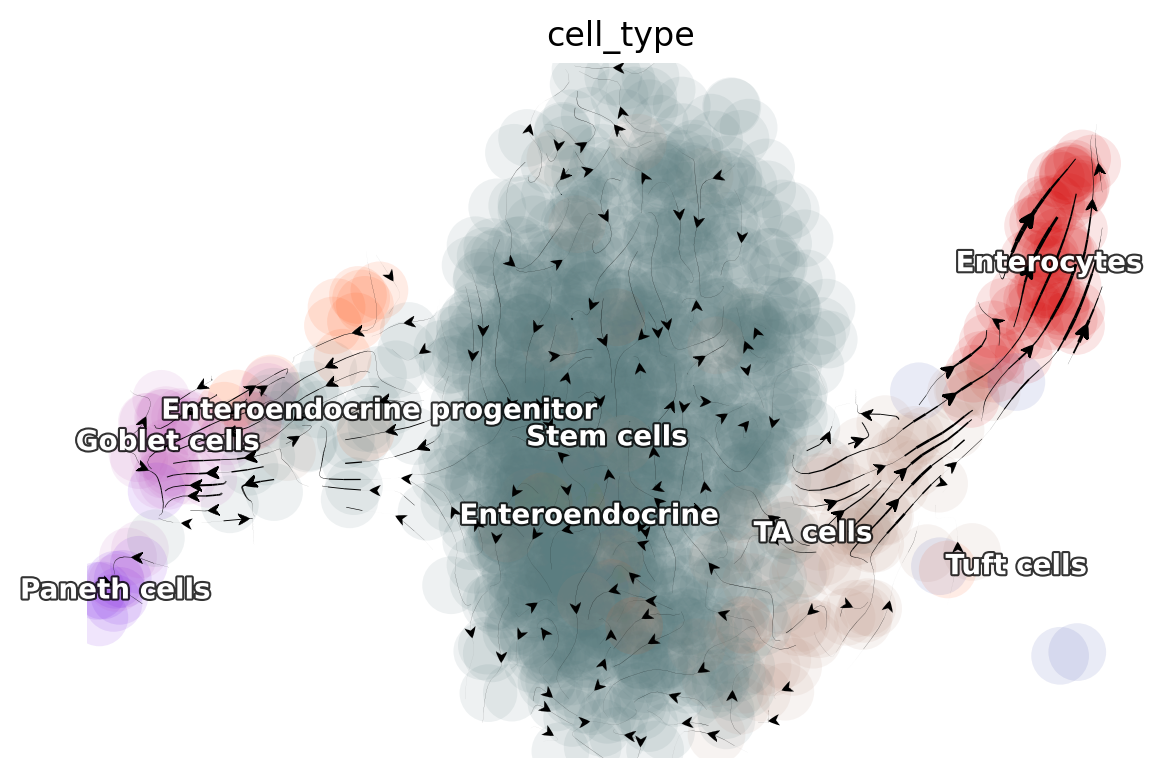

In [19]:
# storm
dyn.pl.streamline_plot(adata_storm, color='cell_type', basis='umap_ori',save_show_or_return='show',
                       save_kwargs={'prefix': 'organoid_storm', 'ext': 'png',
                                    "bbox_inches": None, 'dpi': dpi, 'path': path}, figsize=figsize)

<Figure size 600x400 with 0 Axes>

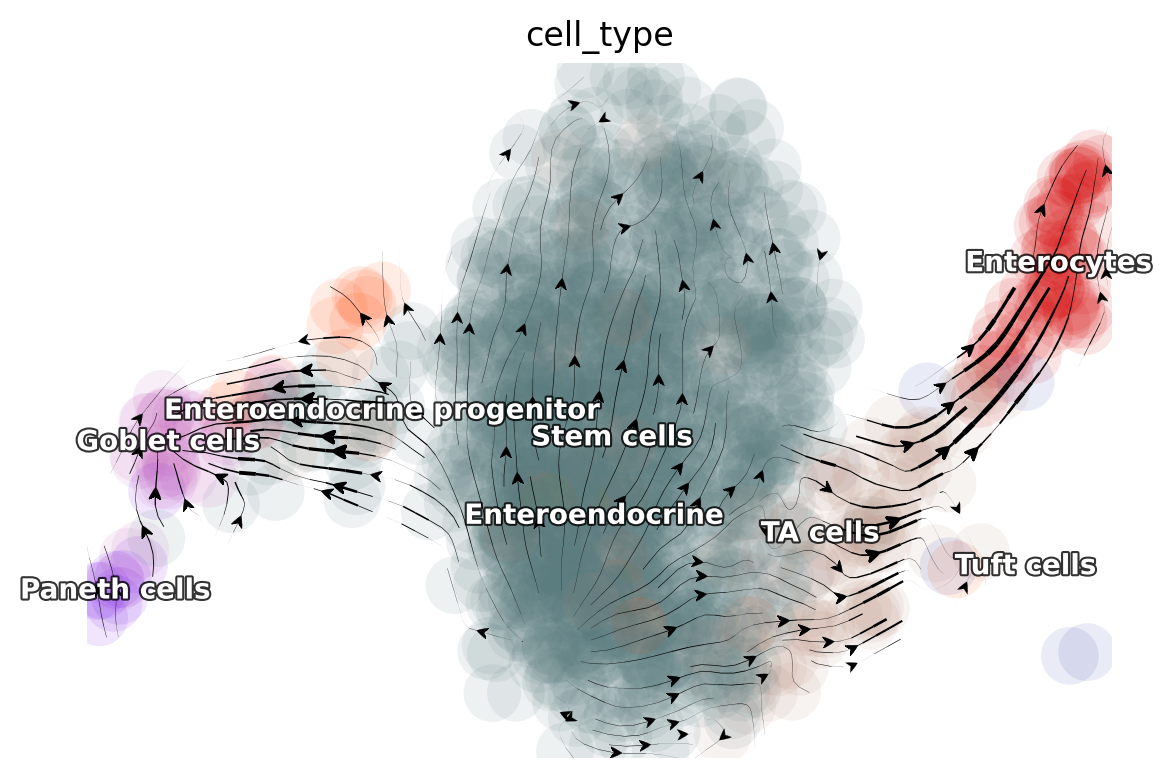

In [21]:
# dynamo
dyn.pl.streamline_plot(adata_dynamo, color='cell_type', basis='umap_ori',save_show_or_return='show',
                       save_kwargs={'prefix': 'organoid_dynamo', 'ext': 'png',
                                    "bbox_inches": None, 'dpi': dpi, 'path': path}, figsize=figsize)

<Figure size 600x400 with 0 Axes>

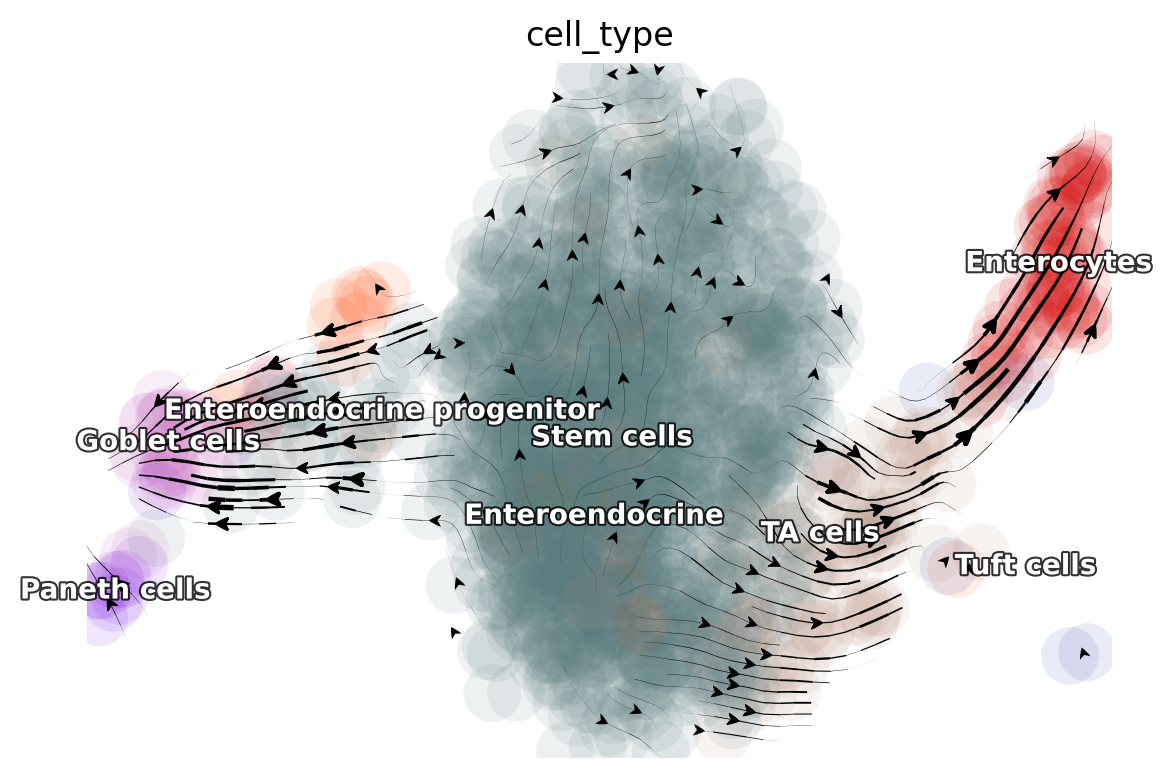

In [23]:
# storm
dyn.pl.streamline_plot(adata_celldancer, color='cell_type', basis='umap_ori',save_show_or_return='show',
                       save_kwargs={'prefix': 'organoid_celldancer', 'ext': 'png',
                                    "bbox_inches": None, 'dpi': dpi, 'path': path}, figsize=figsize)